In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
cdpDir = workDir+'cdp_data'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

In [4]:
# select band
band = '3C'

# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [5]:
# CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
filename = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [6]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 2
Number of groups/frames per integration: 200
Total number of frames: 400
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (400, 1024, 1032)


In [7]:
image_hdu.close()

<IPython.core.display.Javascript object>


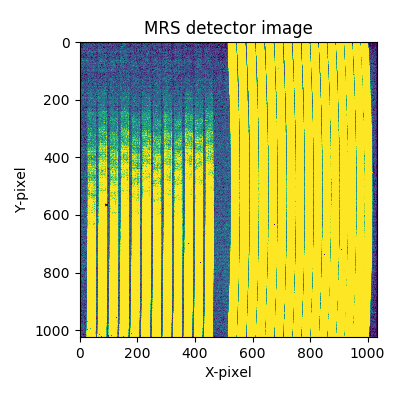

<IPython.core.display.Javascript object>


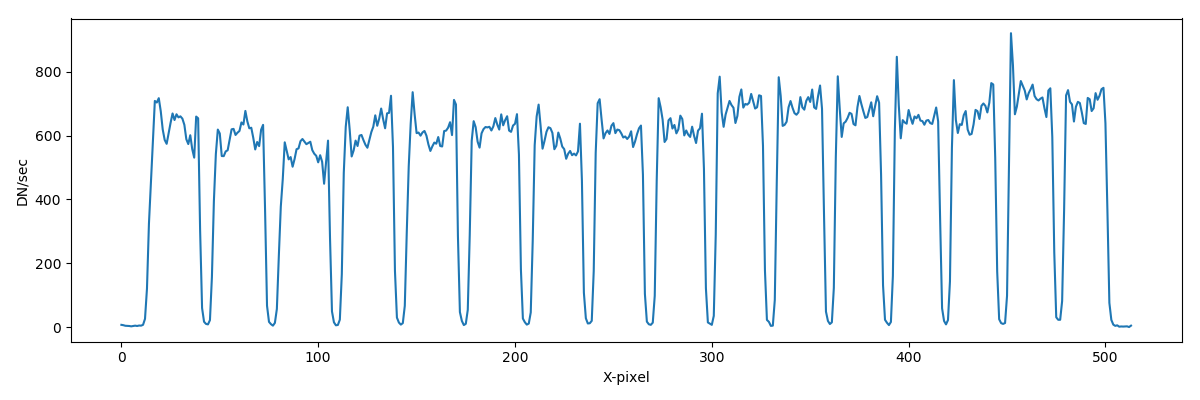

In [10]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=-5,vmax=20)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS detector image')
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(slope_img[row,10:512])
elif band[0] in ['2','3']:
    plt.plot(slope_img[row,512:1026])
plt.xlabel('X-pixel')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


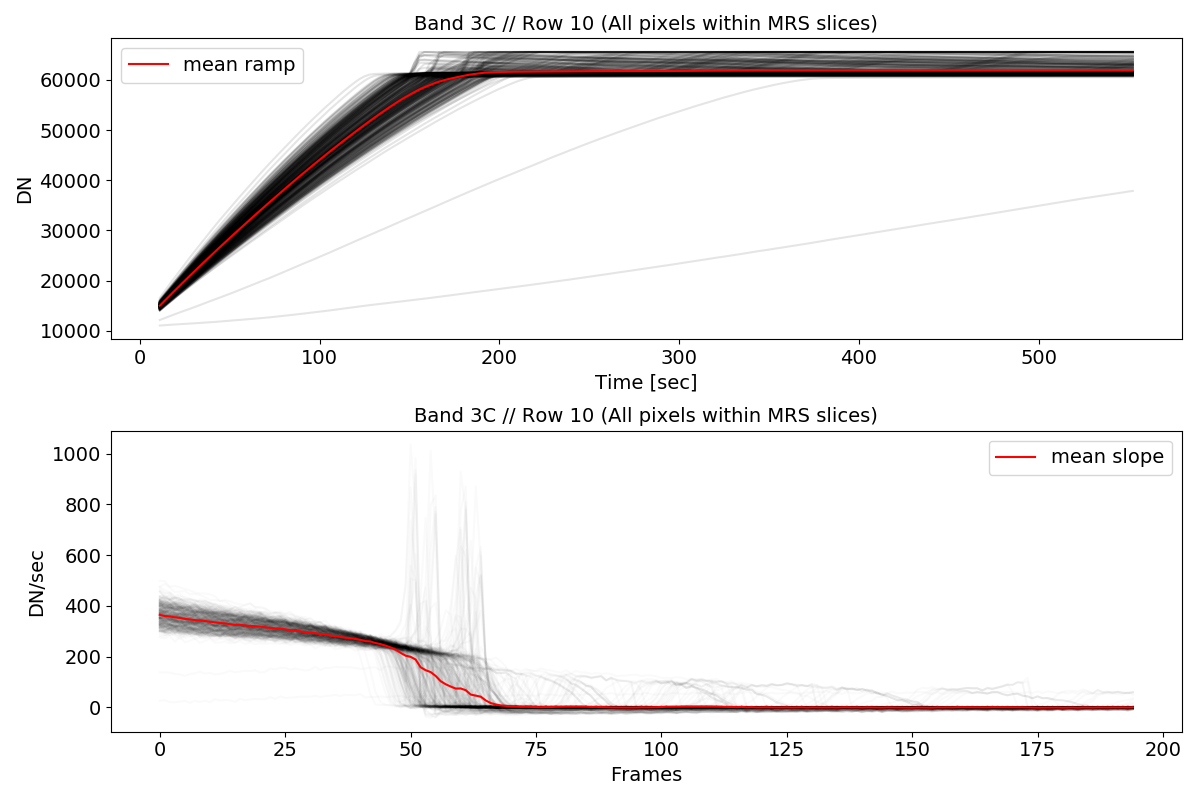

In [9]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
ramp_arr,slope_arr = [],[]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

fig,axs = plt.subplots(2,1,figsize=(12,8))
for ypos in [10]:
    for xpos in range_x:
        if d2cMaps['sliceMap'][ypos,xpos] != 0:
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
            ramp_arr.append(tramp2)
            slope_arr.append(np.diff(tramp2)/frame_delta_time)
            axs[0].plot(time2,tramp2,'k',alpha=0.1)
            axs[1].plot(np.diff(tramp2)/frame_delta_time,'k',alpha=0.02)
ramp_arr = np.array(ramp_arr)
slope_arr = np.array(slope_arr)
axs[0].plot(time3,np.mean(ramp_arr,axis=0),'r',label='mean ramp')
axs[1].plot(np.mean(slope_arr,axis=0),'r',label='mean slope')
axs[0].set_xlabel('Time [sec]',fontsize=14)
axs[0].set_ylabel('DN',fontsize=14)
axs[1].set_xlabel('Frames',fontsize=14)
axs[1].set_ylabel('DN/sec',fontsize=14)
for plot in range(2):
    axs[plot].legend(fontsize=14)
    axs[plot].set_title('Band {} // Row {} (All pixels within MRS slices)'.format(band,ypos),fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=14)
plt.tight_layout()

In [11]:
plt.close('all')

### Compute depth of dip below frame 30 for all pixels

In [12]:
# compute spectral grid
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
specres_table = funcs.get_cdps(band,cdpDir)[4]

oversampling = 2
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table,oversampling = oversampling)

<IPython.core.display.Javascript object>


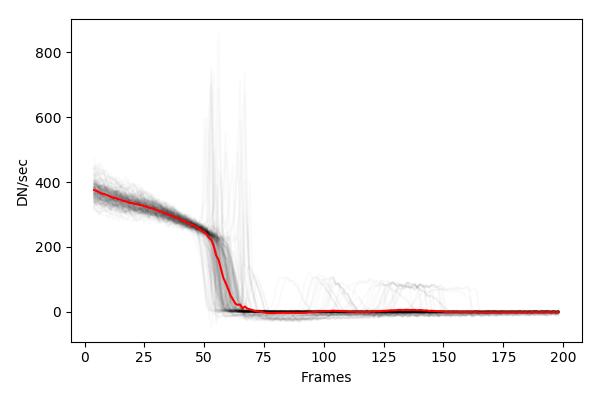

In [13]:
ibin = len(lambcens)-10
coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))

tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])

slope = []
plt.figure(figsize=(6,4))
for i in range(tramp.shape[0]):
    frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
    plt.plot(frames,np.diff(tramp[i,:])/frame_delta_time,'k',alpha=0.02)
    slope.append(np.diff(tramp[i,:])/frame_delta_time)
slope = np.array(slope)
plt.plot(frames,np.mean(slope,axis=0),'r',label='mean slope')
plt.xlabel('Frames')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


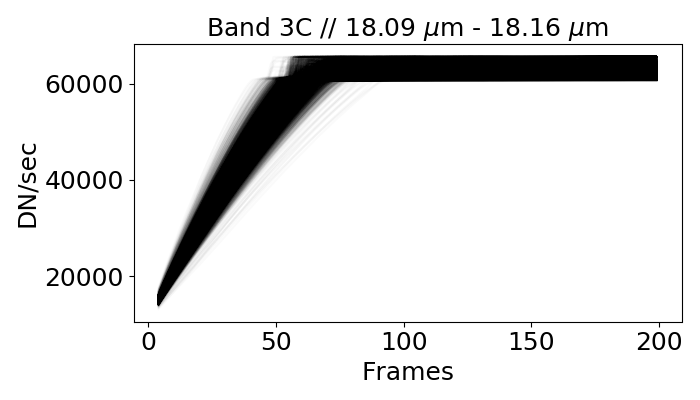

In [14]:
plt.close('all')
plt.figure(figsize=(7,4))
for ibin in range(len(lambcens)-30,len(lambcens)-10): # 10,len(lambcens[::2])-10):
    coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
    tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
    slope = []

    for i in range(tramp.shape[0]):
        if tramp[i,100]>58000:
            plt.plot(1+skip_first+np.arange(len(tramp[i,:])),tramp[i,:],'k',alpha=0.02)
            slope.append(np.diff(tramp[i,:])/frame_delta_time)
    slope = np.array(slope)
    frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
#     plt.plot(frames,np.mean(slope,axis=0),label=np.round(lambcens[ibin]))
plt.xlabel('Frames',fontsize=18)
plt.ylabel('DN/sec',fontsize=18)
plt.title(r'Band {} // {} $\mu$m - {} $\mu$m'.format(band,round(lambcens[len(lambcens)-30],2),round(lambcens[len(lambcens)-10],2)),fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.tight_layout()

<IPython.core.display.Javascript object>


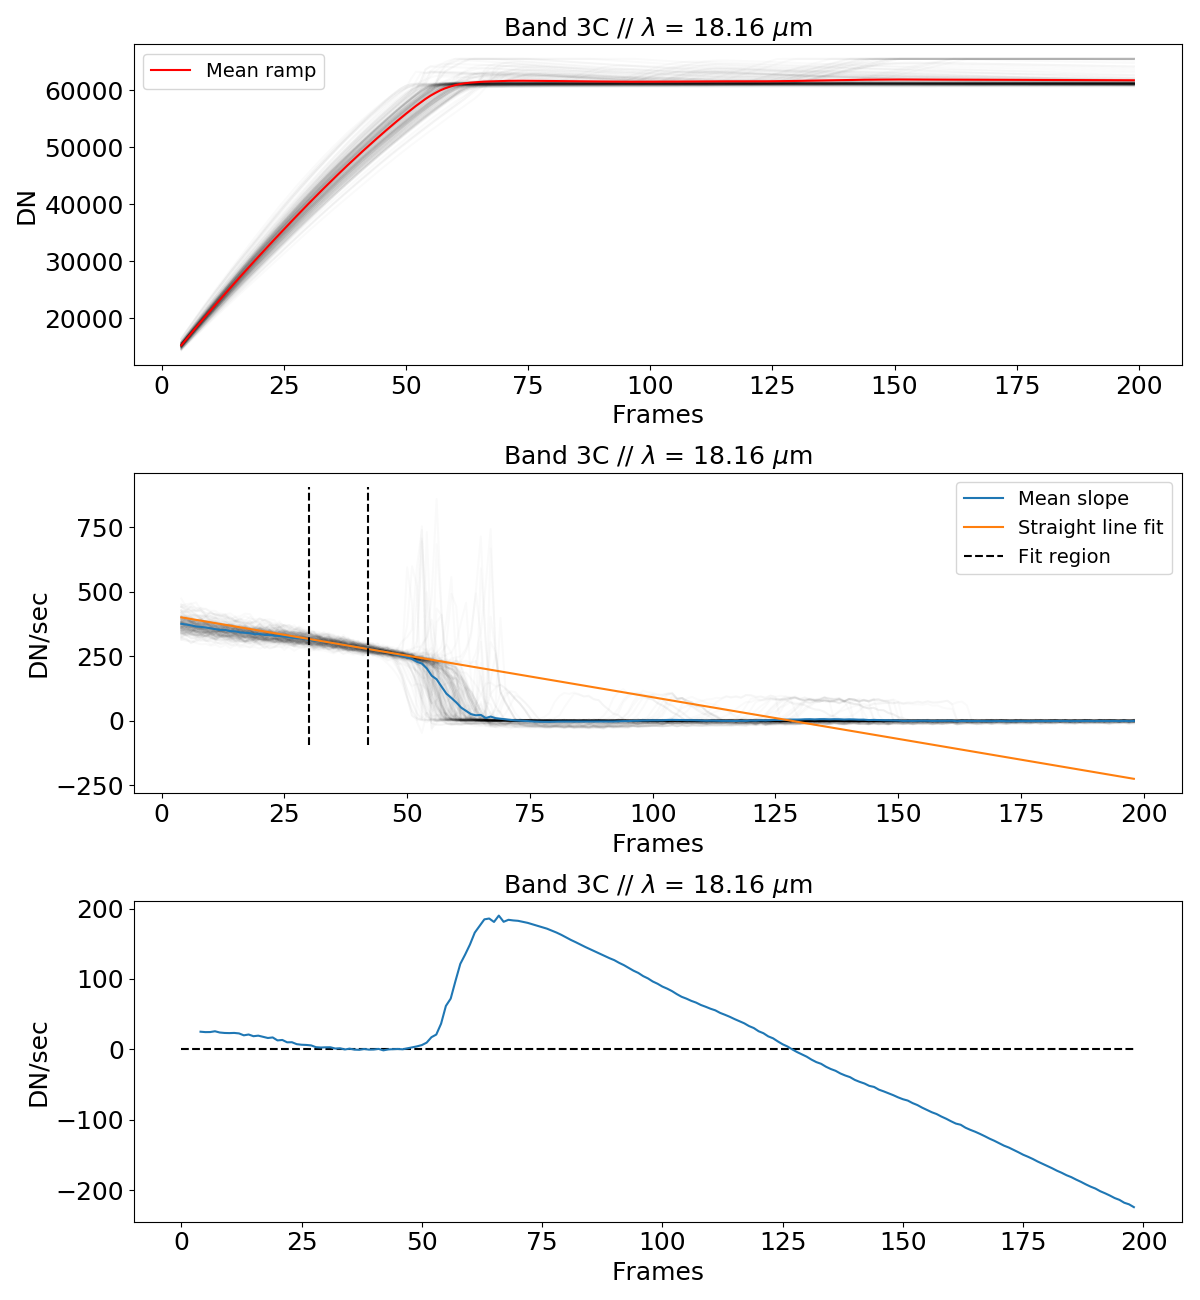

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [16]:
plt.close('all')
fig,axs = plt.subplots(3,1,figsize=(12,13))
for ibin in [len(lambcens)-10]: # range(10,len(lambcens[::2])-10):
    coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
    tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
    slope = []
    tramp_len = []
    for i in range(tramp.shape[0]):
        if (tramp[i,0]<30000) & (tramp[i,100]>58000):
            axs[0].plot(1+skip_first+np.arange(len(tramp[i,:])),tramp[i,:],'k',alpha=0.02,zorder=0)
            axs[1].plot(1+skip_first+np.arange(len(tramp[i,:]))[:-1],np.diff(tramp[i,:])/frame_delta_time,'k',alpha=0.02,zorder=0)
            slope.append(np.diff(tramp[i,:])/frame_delta_time)
            tramp_len.append(len(tramp[i,:][tramp[i,:]<58000]))
    slope,tramp_len = np.array(slope),np.array(tramp_len)
    min_len = min(tramp_len)
    frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
    
    axs[0].plot(1+skip_first+np.arange(len(tramp[i,:])),np.mean(tramp,axis=0),'r',label='Mean ramp',zorder=1)
    axs[1].plot(frames,np.mean(slope,axis=0),label='Mean slope',zorder=1)
    bottom, top = axs[1].get_ylim()
    if band == '4C':
        if min_len>60:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[60:min_len], np.mean(slope,axis=0)[60:min_len], 1)
            axs[1].vlines([60,min_len],bottom, top,'k',linestyle='dashed',label='Fit region',zorder=3)
            axs[1].plot(frames,bias+linear_term*frames,label='Straight line fit',zorder=2)
    elif band == '4B':
        if min_len>40:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[40:min_len], np.mean(slope,axis=0)[40:min_len], 1)
            axs[1].vlines([40,min_len],bottom, top,'k',linestyle='dashed',label='Fit region',zorder=3)
            axs[1].plot(frames,bias+linear_term*frames,label='Straight line fit',zorder=2)
    elif band == '4A':
        if min_len>35:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[35:min_len], np.mean(slope,axis=0)[35:min_len], 1)
            axs[1].vlines([35,min_len],bottom, top,'k',linestyle='dashed',label='Fit region',zorder=3)
            axs[1].plot(frames,bias+linear_term*frames,label='Straight line fit',zorder=2)
    elif band == '3C':
        if min_len>30:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[30:min_len], np.mean(slope,axis=0)[30:min_len], 1)
            axs[1].vlines([30,min_len],bottom, top,'k',linestyle='dashed',label='Fit region',zorder=3)
            axs[1].plot(frames,bias+linear_term*frames,label='Straight line fit',zorder=2)
    try:
        axs[2].plot(frames,bias+linear_term*frames - np.mean(slope,axis=0))
    except:
        print ibin
axs[2].hlines(0,0,frames[-1],'k',linestyle='dashed')
axs[0].set_ylabel('DN',fontsize=18)
axs[1].set_ylabel('DN/sec',fontsize=18)
axs[2].set_ylabel('DN/sec',fontsize=18)
axs[2].set_title(r'Fitted line - mean slope',fontsize=18)
for plot in range(3):
    axs[plot].set_xlabel('Frames',fontsize=18)
    axs[plot].set_title(r'Band {} // $\lambda$ = {} $\mu$m'.format(band,round(lambcens[ibin],2)),fontsize=18)
    axs[plot].legend(fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=18)
plt.tight_layout()

### Analyze bands 3C, 4A, 4B, and 4C

In [7]:
# select ramp
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [4]:
image_data_dic = {}
ngroups_dic,frame_delta_time_dic = {},{}
d2cMaps_dic,specres_table_dic = {},{}
lambcens_dic,lambfwhms_dic = {},{}
for band in ['3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    
    # CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
    filename = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

    # load data
    image_hdu = fits.open(filename)
    image_data_dic[band] = fits.getdata(filename)[:,:1024,:].astype('float')
    
    ngroups_dic[band]     = image_hdu[0].header['NGROUP']
    frame_delta_time_dic[band] = image_hdu[0].header['TFRAME']
    
    image_hdu.close()
    
    d2cMaps_dic[band] = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    specres_table_dic[band] = funcs.get_cdps(band,cdpDir)[4]
    
    # compute spectral grid
    oversampling = 2
    lambcens_dic[band],lambfwhms_dic[band] = funcs.spectral_gridding(band,d2cMaps_dic[band],specres_table=specres_table_dic[band],oversampling = oversampling)

Band 3C
Band 4A
Band 4B
Band 4C


In [36]:
plt.close('all')

fit_region_lower_dic = {'4C':60,'4B':40,'4A':35,'3C':31}
fit_region_lower_dic = {'4C':30,'4B':30,'4A':30,'3C':30}
# ramps_dic,frames_dic,norm_signal_dic,amplitude_dic,smoothed_amplitude_dic,integrated_signal_dic = {},{},{},{},{},{}
for band in ['3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    
    # inputs
    d2cMaps = d2cMaps_dic[band]
    image_data = image_data_dic[band]
    ngroups = ngroups_dic[band]
    frame_delta_time = frame_delta_time_dic[band]
    lambcens,lambfwhms = lambcens_dic[band],lambfwhms_dic[band]
    low_lim = fit_region_lower_dic[band]
    
    frames_dic[band] = []
    norm_signal_dic[band] = []
    amplitude_dic[band] = np.zeros(len(lambcens))
    smoothed_amplitude_dic[band] = np.zeros(len(lambcens))
    integrated_signal_dic[band] = np.zeros(len(lambcens))
    
#     plt.figure(figsize=(12,4))
    for ibin in range(10,len(lambcens)-11):
        coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
        tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
        slope = []
        tramp_len = []
        for i in range(tramp.shape[0]):
            if band == '3C':
                if (tramp[i,:][0]<30000) & (tramp[i,:][100]>58000):
                    slope.append(np.diff(tramp[i,:])/frame_delta_time)
                    tramp_len.append(len(tramp[i,:][tramp[i,:]<58000]))
                    plt.plot(1+skip_first+np.arange(len(tramp[i,:])),tramp[i,:],'k',alpha=0.3,zorder=0)
            elif band == '4A':
                if (tramp[i,:][0]<30000):# & (tramp[i,:][50]>30000):
                    slope.append(np.diff(tramp[i,:])/frame_delta_time)
                    tramp_len.append(len(tramp[i,:][tramp[i,:]<58000]))
#                     plt.plot(1+skip_first+np.arange(len(tramp[i,:])),tramp[i,:],'k',alpha=0.3,zorder=0)
#         plt.plot(1+skip_first+np.arange(len(tramp[i,:])),np.mean(tramp,axis=0),'r',label='Mean ramp',zorder=1)
#         plt.xlabel('Frames',fontsize=18)
#         plt.ylabel('DN',fontsize=18)
#         plt.title(r'Band {} // $\lambda$ = {} $\mu$m'.format(band,round(lambcens[ibin],2)),fontsize=18)
#         plt.legend(fontsize=14)
#         plt.tick_params(axis='both',labelsize=18)
#         plt.tight_layout()

        slope,tramp_len = np.array(slope),np.array(tramp_len)
        min_len = min(tramp_len)
        frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
        
        if min_len<=fit_region_lower_dic['3C']:
            continue
        else:
            if min_len>low_lim+1:
                    bias,linear_term = np.polynomial.polynomial.polyfit(frames[low_lim:min_len], np.mean(slope,axis=0)[low_lim:min_len], 1)

            frames_dic[band].append(frames)
            norm_signal_dic[band].append((bias+linear_term*frames)-np.mean(slope,axis=0))
            integrated_signal_dic[band][ibin] = np.sum(((bias+linear_term*frames)-np.mean(slope,axis=0))[:low_lim])*frame_delta_time # DN

Band 4A


<IPython.core.display.Javascript object>


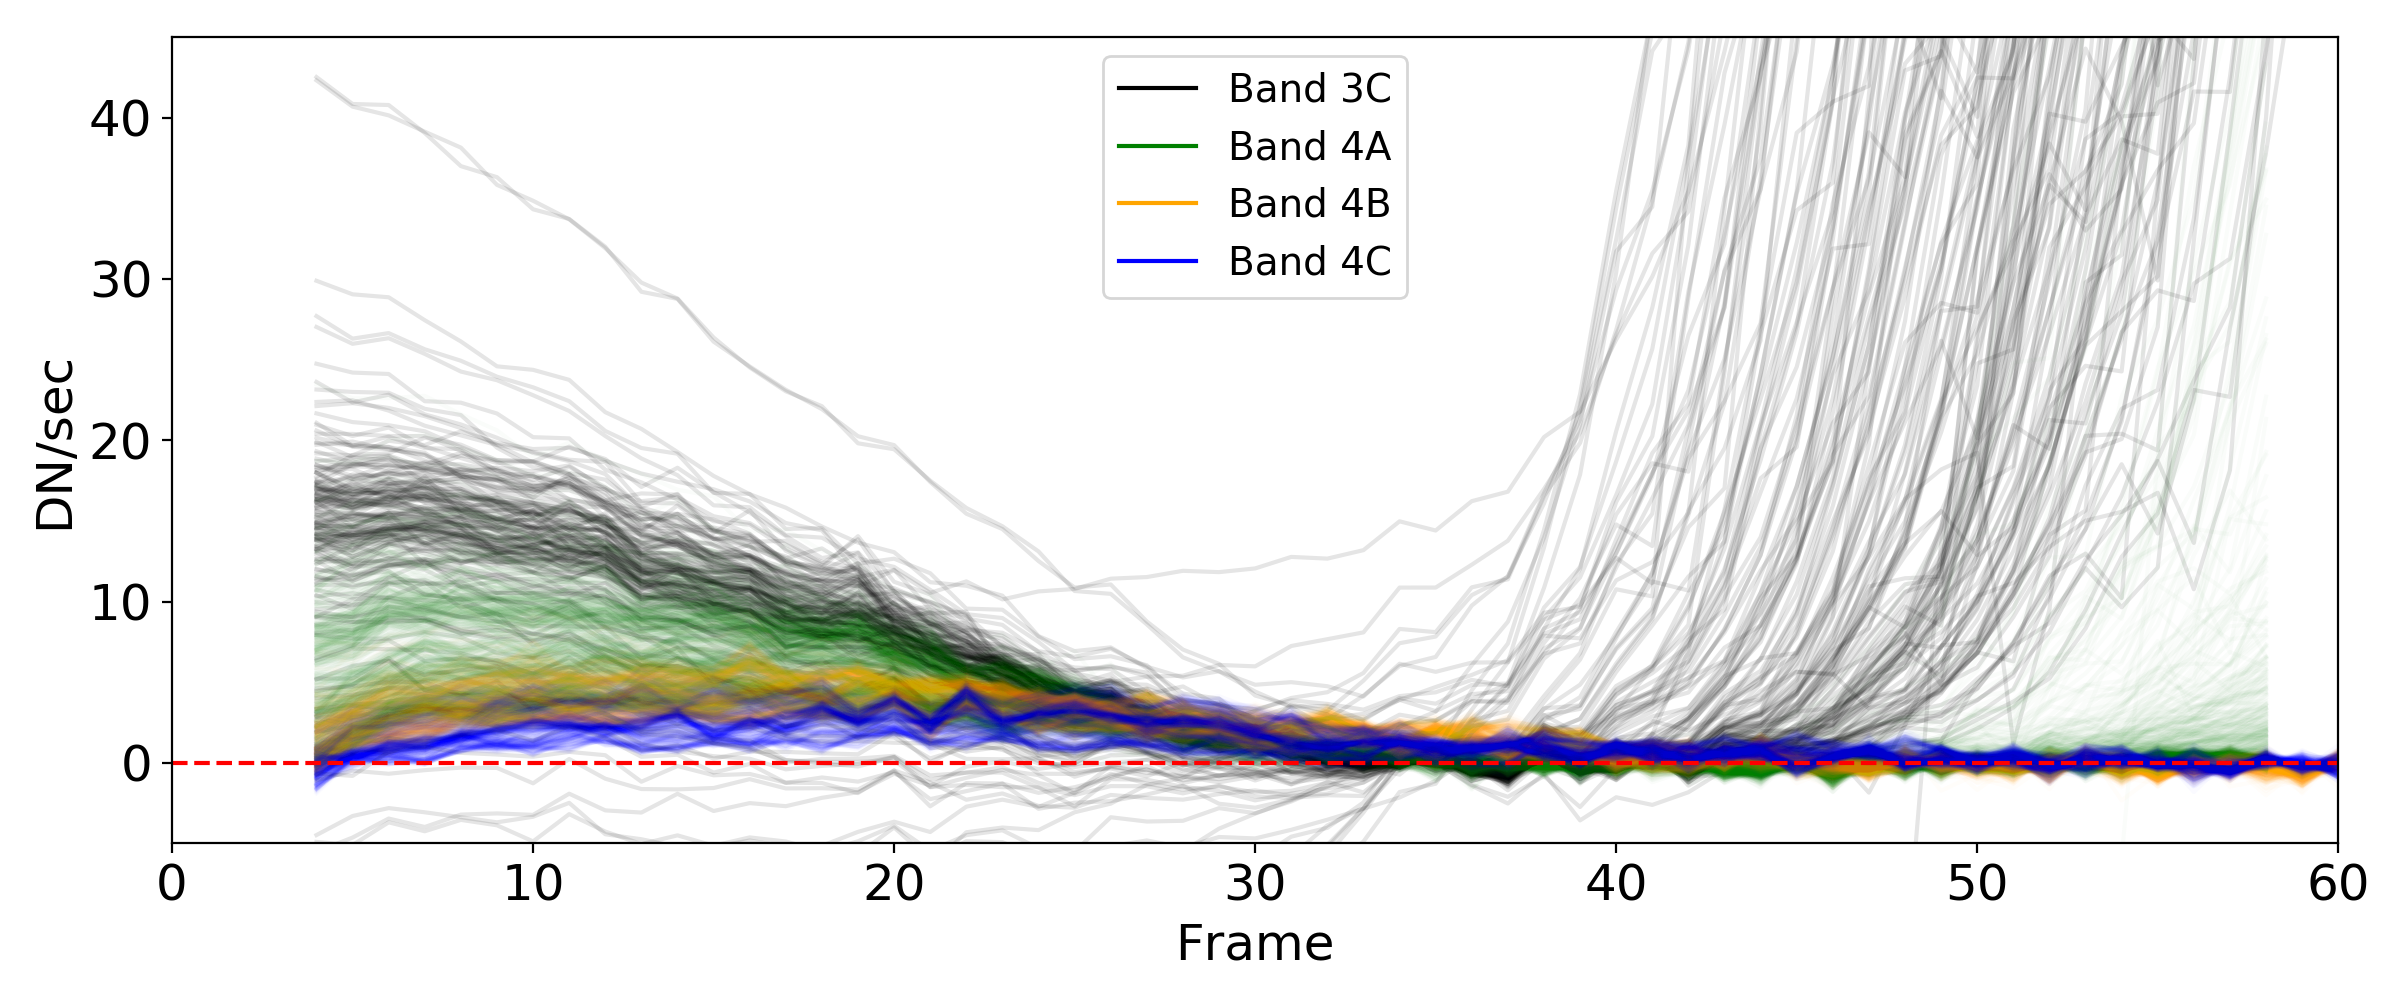

In [37]:
plt.close('all')
colors = {'4C':'b','4B':'orange','4A':'g','3C':'k'}
opacities = {'4C':0.02,'4B':0.02,'4A':0.02,'3C':0.1}

plt.figure(figsize=(12,5))
for band in ['3C','4A','4B','4C']:
    for i in range(len(frames_dic[band])):
        plt.plot(frames_dic[band][i],norm_signal_dic[band][i],colors[band],alpha=opacities[band],zorder=0)
plt.hlines(0,0,200,'r',linestyle='dashed',zorder=1)
plt.xlim(0,60)
plt.ylim(-5,45)
plt.xlabel('Frame',fontsize=18)
plt.ylabel('DN/sec',fontsize=18)
legend_elements = [Line2D([0],[0],color='k',label='Band 3C'),
                   Line2D([0],[0],color='g',label='Band 4A'),
                   Line2D([0],[0],color='orange',label='Band 4B'),
                   Line2D([0],[0],color='b',label='Band 4C')]
plt.legend(handles=legend_elements,loc='best',fontsize=14)
plt.tick_params(axis='both',labelsize=18)
plt.tight_layout()

<IPython.core.display.Javascript object>


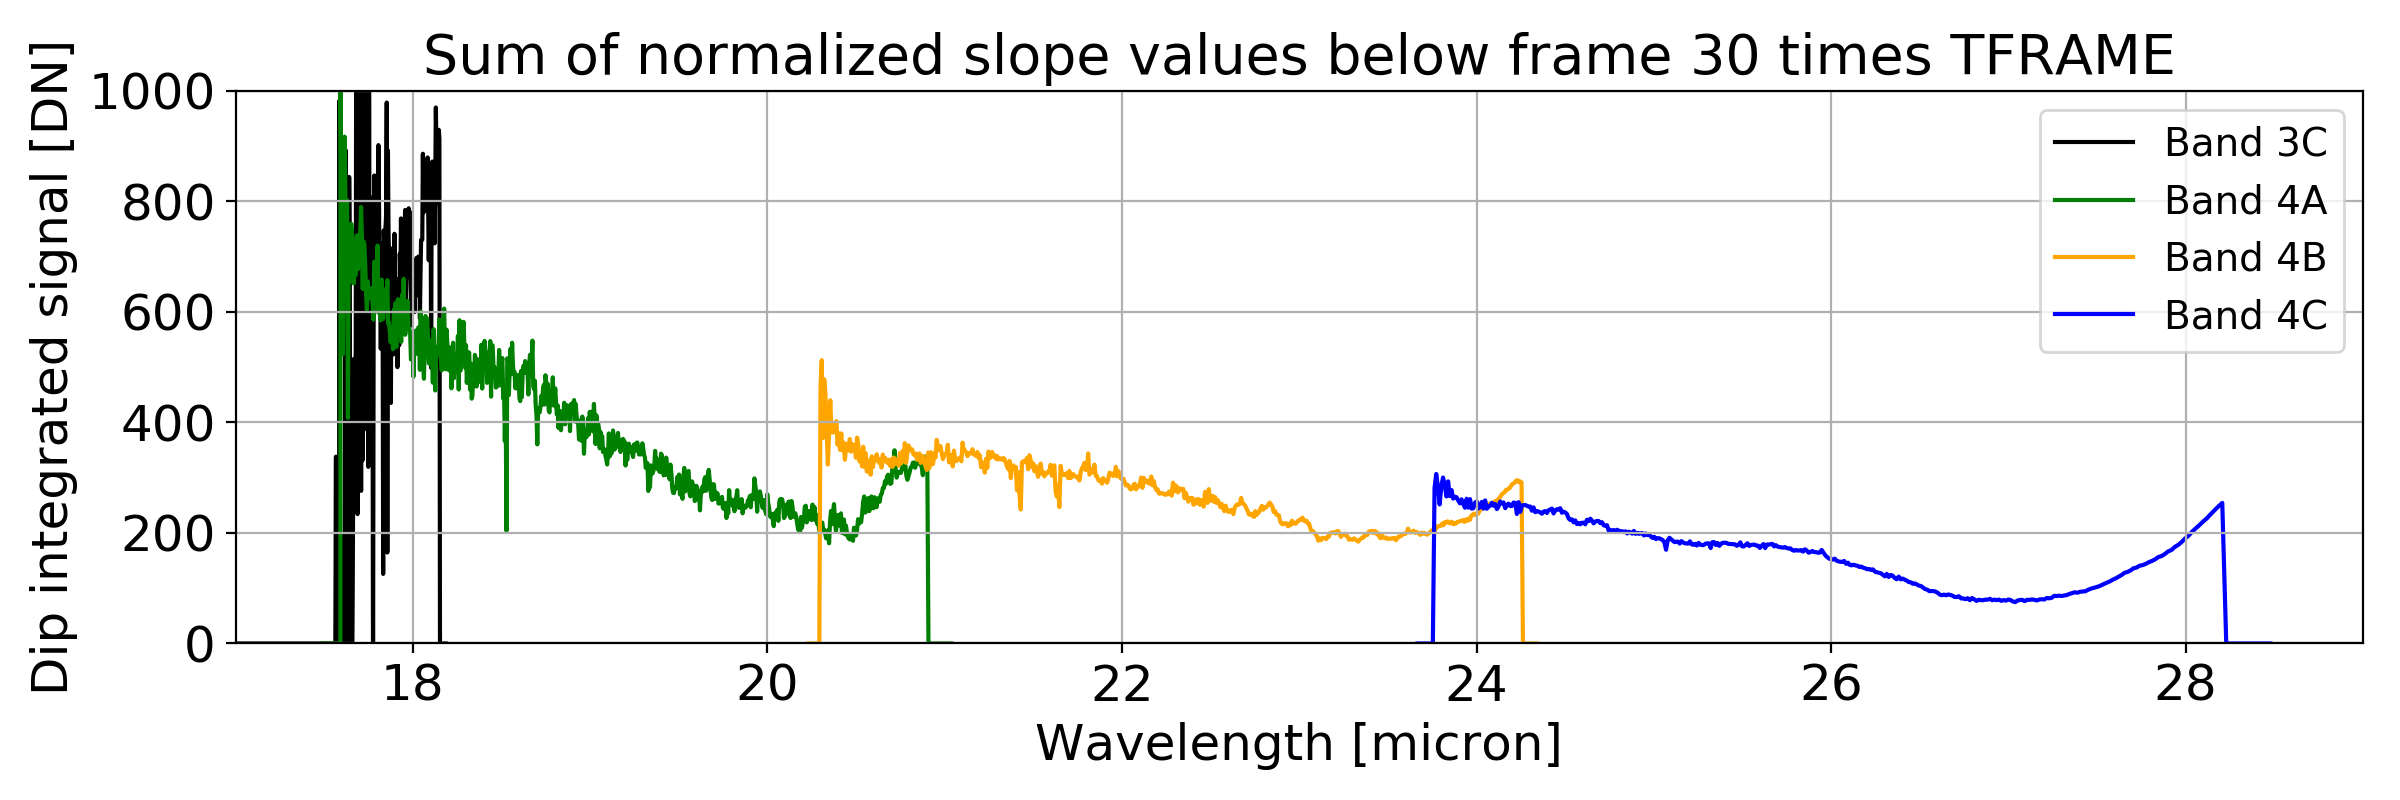

In [38]:
plt.close('all')

colors = {'4C':'b','4B':'orange','4A':'g','3C':'k'}
plt.figure(figsize=(12,4))
for band in ['3C','4A','4B','4C']:
    plt.plot(lambcens_dic[band],integrated_signal_dic[band],colors[band],zorder=0,label='Band {}'.format(band))
plt.xlim(17,29)
plt.ylim(0,1000)
plt.title('Sum of normalized slope values below frame 30 times TFRAME',fontsize=20)
plt.xlabel('Wavelength [micron]',fontsize=18)
plt.ylabel('Dip integrated signal [DN]',fontsize=18)
plt.legend(loc='upper right',fontsize=14)
plt.tick_params(axis='both',labelsize=18)
plt.grid()
plt.tight_layout()